# <a id="2">Load packages</a>

In [3]:
#DID THIS ON KAGGLE SO A LOT OF EXTRA STEPS FOR EXTRACTING THE DATA AND ETC.....
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.applications import ResNet50  # Updated import
from tensorflow.keras.models import Sequential  # Updated import
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D  # Updated import

%matplotlib inline 


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
BATCH_SIZE = 32  
NO_EPOCHS = 3   
SAMPLE_SIZE = 100 
TEST_SIZE = 0.2  
PATH = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/'
TRAIN_FOLDER = './train/'
TEST_FOLDER =  './test/'
IMG_SIZE = 224
RESNET_WEIGHTS_PATH = '/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [5]:
train_image_path = os.path.join(PATH, "train.zip")
test_image_path = os.path.join(PATH, "test.zip")

In [6]:
import zipfile
with zipfile.ZipFile(train_image_path,"r") as z:
    z.extractall(".")

In [7]:
with zipfile.ZipFile(test_image_path,"r") as z:
    z.extractall(".")

In [8]:
train_image_list = os.listdir("./train/")[0:SAMPLE_SIZE]
test_image_list = os.listdir("./test/")

In [9]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

In [10]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [11]:
train = process_data(train_image_list, TRAIN_FOLDER)

100%|██████████| 100/100 [00:00<00:00, 445.16it/s]


Then, we plot the image selection.

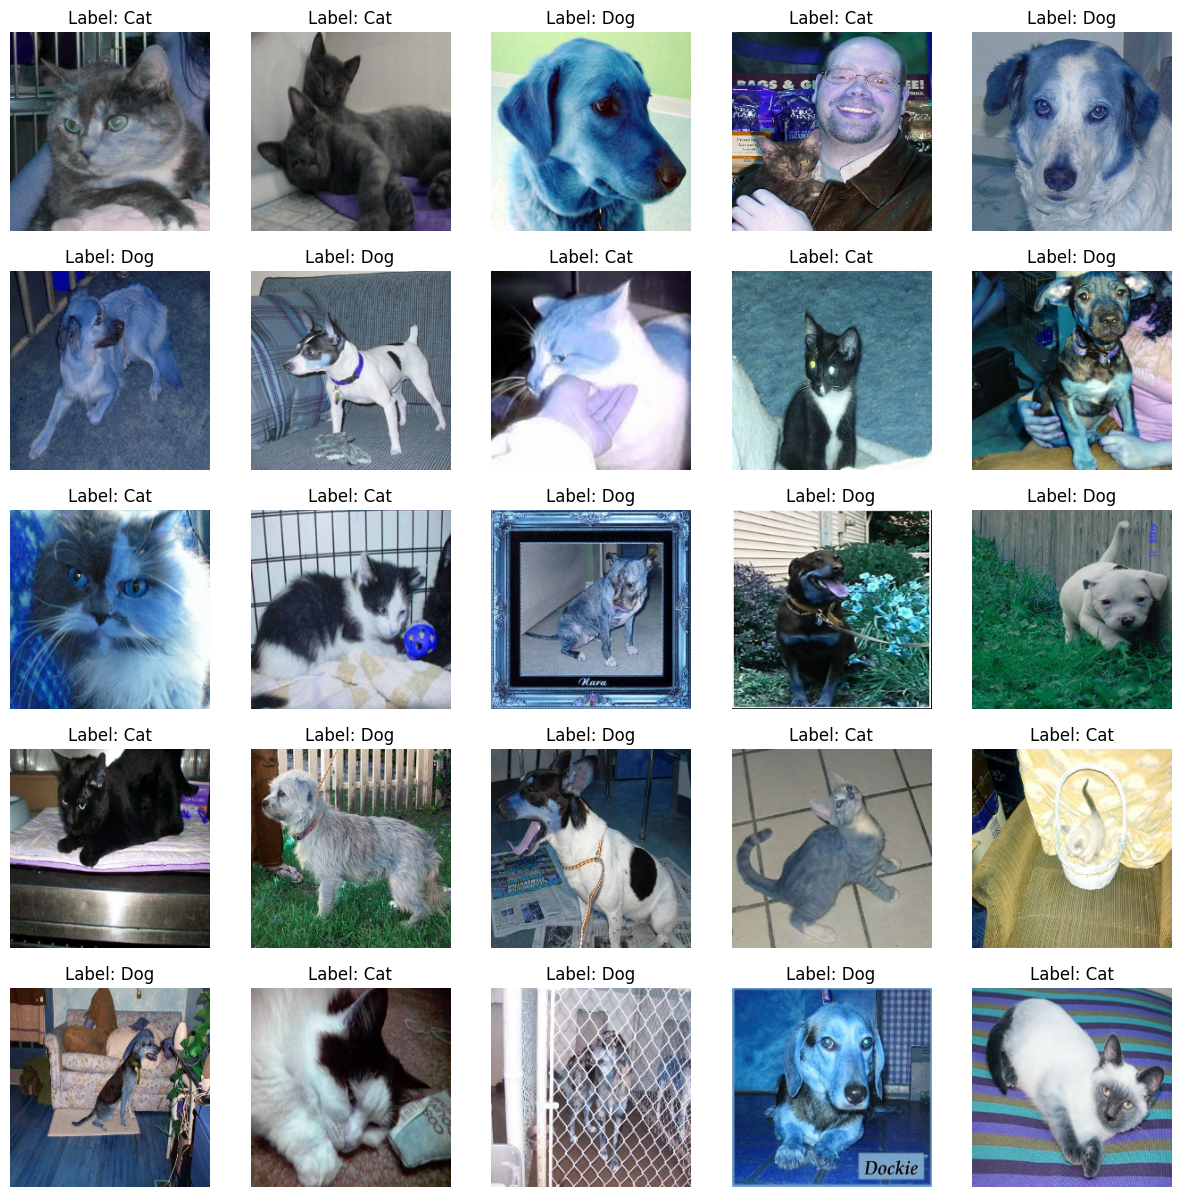

In [12]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(train)

Let's also show a selection of the train set. We prepare the test set.

In [13]:
test = process_data(test_image_list, TEST_FOLDER, False)

100%|██████████| 12500/12500 [00:27<00:00, 460.76it/s]


In [14]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [18]:
NUM_CLASSES = 2 
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', input_shape=(224, 224, 3)))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

In [19]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

In [26]:
RANDOM_STATE = np.random.RandomState()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [27]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/3
3/3 [==============================] - 27s 2s/step - loss: 94.3800 - accuracy: 0.4375 - val_loss: 83.0463 - val_accuracy: 0.7000
Epoch 2/3
3/3 [==============================] - 0s 166ms/step - loss: 31.1545 - accuracy: 0.6625 - val_loss: 11278504.0000 - val_accuracy: 0.3000
Epoch 3/3
3/3 [==============================] - 1s 173ms/step - loss: 36.6672 - accuracy: 0.6250 - val_loss: 533945.8750 - val_accuracy: 0.7000


In [28]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 533945.875
Validation accuracy: 0.699999988079071
